# Residuals Diagnostics Example

In this notebook, we have developed an example of residuals diagnostics for a score-driven model with the package built-in functions.

## Import packages

In [4]:
import Pkg
Pkg.add(url="https://github.com/LAMPSPUC/UnobservedComponentsGAS.git")

using CSV
using DataFrames
using Plots
using UnobservedComponentsGAS

## Read ENA dataset

ENA, in portuguese *Energia Natural Afluente*, means natural inflow energy.

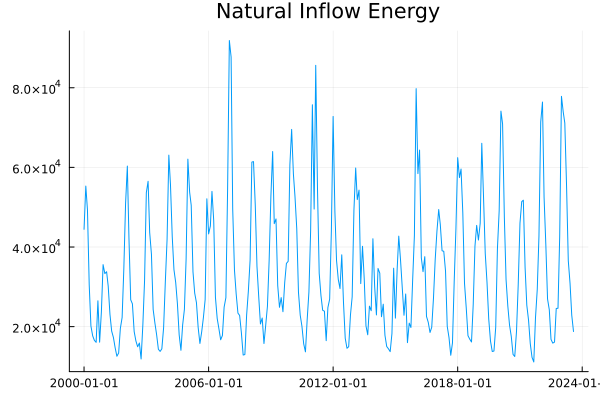

In [63]:
data = CSV.read("data/ena.csv", DataFrame)

y     = data[:, 2]
dates = data[:, 1]

plot(title = "Natural Inflow Energy")
plot!(dates, y, label = "")

## Defining and estimating a Score-Driven Model

Model specifications:
 - Distribution: tLocationScale
 - Only the mean parameter as time varying
 - d = 1
 - level component: random walk process
 - seasonality component: deterministic with 12 seasonal periods (monthly seasonality)
 - ar component: AR(2)

In [64]:
time_varying_parameters = [true, false, false]
dist                    = UnobservedComponentsGAS.tLocationScaleDistribution()
d                       = 1.0
num_scenarious          = 500

level       = "random walk"
seasonality = "deterministic 12"
ar          = 2

model = UnobservedComponentsGAS.GASModel(dist, time_varying_parameters, d, level,seasonality, ar)

Main.UnobservedComponentsGAS.GASModel(Main.UnobservedComponentsGAS.tLocationScaleDistribution(missing, missing, missing), Bool[1, 0, 0], 1.0, ["random walk", "", ""], ["deterministic 12", "", ""], Union{Missing, Int64}[2, missing, missing])

## Fit the model 

In [ ]:
fitted_model = UnobservedComponentsGAS.fit(model, y);

## Plot the fitted values

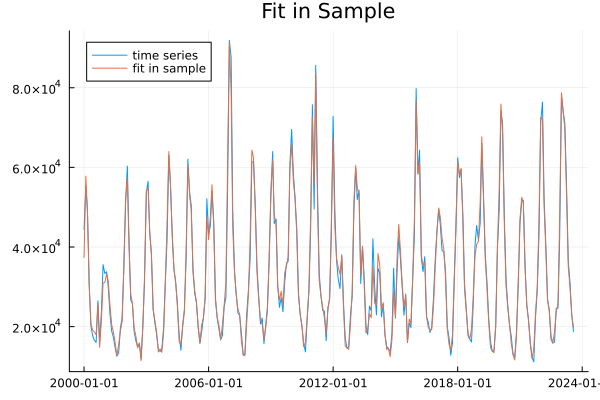

In [66]:
plot(title = "Fit in Sample")
plot!(dates, y, label = "time series")
plot!(dates,fitted_model.fit_in_sample, label = "fit in sample")

## How to acess every residual

The *fitted_model* object has a key *residuals* which is a dictionary containing 3 keys, one for each type of residuals:
 - **Standardized residuals**: contains a vector of the same length as the fitted time series
 - **Quantile residuals**: contains a vector of the same length as the fitted time series
 - **Conditional Score residuals**:  contains a matrix with as many rows as the length of the fitted time series and as many columns as the number of parameters of the chosen distribution.

Note that we have opted to exclude the initial element from all residuals. This decision was made because, frequently, the initial residual does not yield reliable information due to model initialization. In order to plot those residuals, we have also truncated the dates vector.

In [67]:
std_residuals               = fitted_model.residuals["std_residuals"][2:end]
quantile_residuals          = fitted_model.residuals["q_residuals"][2:end]
conditional_score_residuals = fitted_model.residuals["cs_residuals"][2:end,:]
cs_residuals_param_1        = conditional_score_residuals[:,1]
cs_residuals_param_2        = conditional_score_residuals[:,2]

residuals_dates             = dates[2:end];

### Package built-in function

The package has a built in function that returns the specified residuals: 
 - *get_residuals(fitted_model; type)*

It has 2 parameters: the fitted model, of type *UnobservedComponents.Output* and a string *type* specifying the type of the residuals
 - *std* - stardirdized residuals
 - *q* - quantile residuals *(default)*
 - *cs* - conditional score residuals

It is important to note that the first residual is dropped, as previoulsy explanained.

In [68]:
std_residuals               = UnobservedComponentsGAS.get_residuals(fitted_model; type = "std")
quantile_residuals          = UnobservedComponentsGAS.get_residuals(fitted_model; type = "q")
conditional_score_residuals = UnobservedComponentsGAS.get_residuals(fitted_model; type = "cs")

println("Length of time series used for model fitting: $(length(y))")
println("Length of residuals from the fitted model: $(length(quantile_residuals))")

Length of time series used for model fitting: 284
Length of residuals from the fitted model: 283


## Plot residuals

The package has a built-in function called 
 - *plot_residuals(fitted_model; type)*.

It has the same parameters as the previous function and the default value for the *type* is always the "*q*".

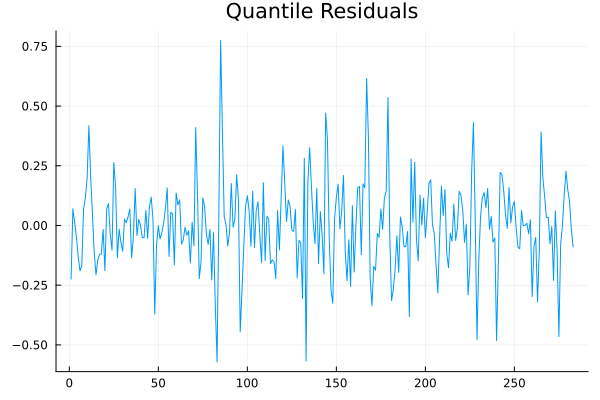

In [69]:
UnobservedComponentsGAS.plot_residuals(fitted_model)

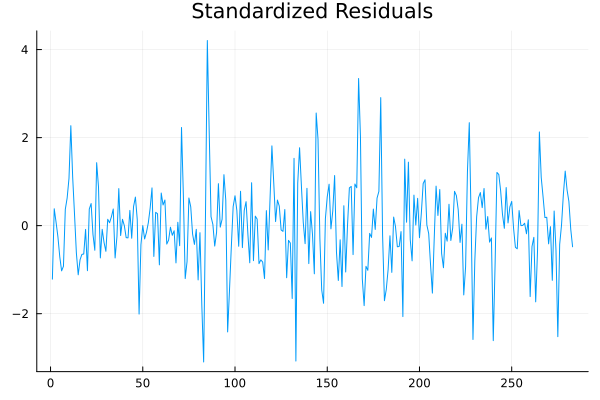

In [70]:
UnobservedComponentsGAS.plot_residuals(fitted_model; type = "std")

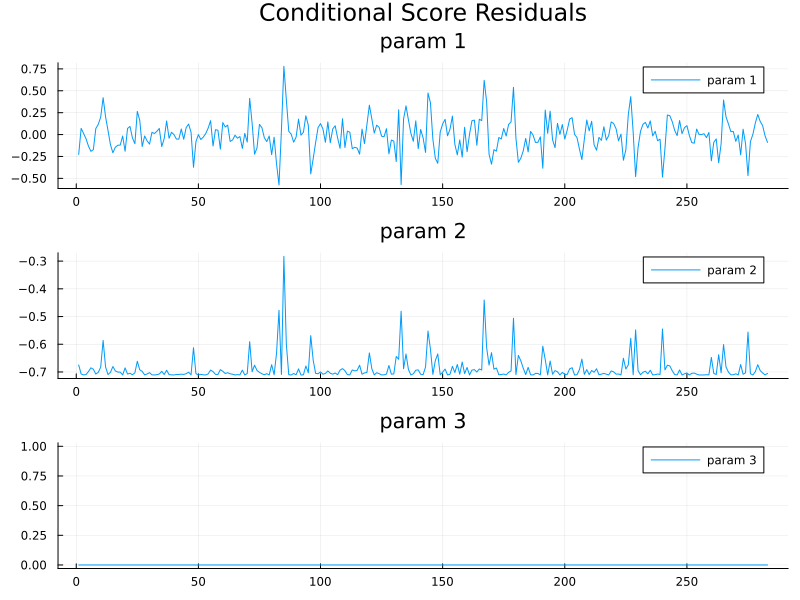

In [71]:
UnobservedComponentsGAS.plot_residuals(fitted_model; type = "cs")

## AutoCorrelation Function

As it is almost mandatory in time series modeling, one should always check the autocorrelation function in order to study the presence of autocorrelation in the model residuals, since it should be free of it.

With that in mind, the package has two built in functions: 
 - *get_acf_residuals(fitted_model; lags, type, squared)*
 - *plot_acf_residuals(fitted_model; type , lags, squared)*.

Both have the same parameters: the fitted model's output, the type of the residuals as a *string*, the quantity of *lags* as an integer, for which the default is 25, and *squared* which is a boolean flag to indicate if the acf should be calculated for the squared residuals.

Note that both functions return/plot the acf value for the lag 0, which is always equal to 1.

In [72]:
UnobservedComponentsGAS.get_acf_residuals(fitted_model; lags = 6, type = "q", squared = false)

7-element Vector{Float64}:
  1.0
  0.2515891432445239
 -0.10082210689450032
 -0.1870116657570155
 -0.18177872072870901
 -0.09356057893281967
 -0.09167263369657085

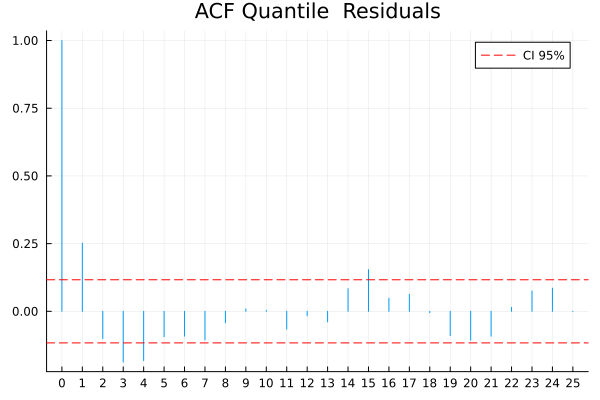

In [73]:
UnobservedComponentsGAS.plot_acf_residuals(fitted_model; type = "q", lags = 25, squared = false)

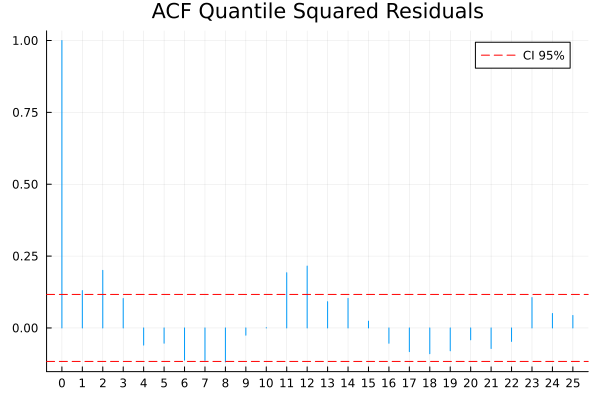

In [74]:
UnobservedComponentsGAS.plot_acf_residuals(fitted_model; type = "q", lags = 25, squared = true)

## Investigatig normality: histogram and qqplot

There is also built-in functions that plot both the residuals histogram and its qqplot for a standart normal distribution.

The first is: 
 - *plot_histogram(output; type, bins)*, which takes as parameters the fitted model's output, the residuals' type and the number of bins to plot

The second is: 
 - *plot_qqplot(output; type = "q")*, which takes as parameters the fitted model's output and the residuals' type.

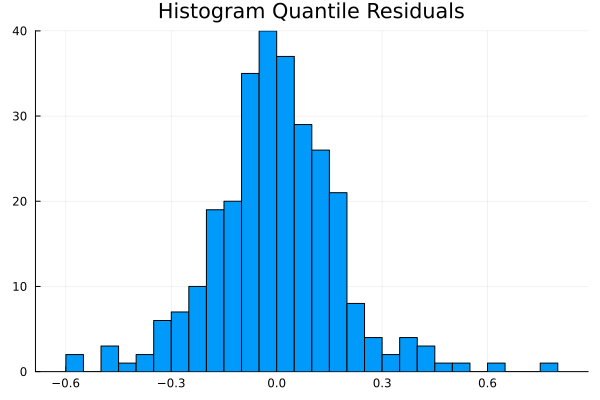

In [75]:
UnobservedComponentsGAS.plot_histogram(fitted_model; type ="q", bins = 50)

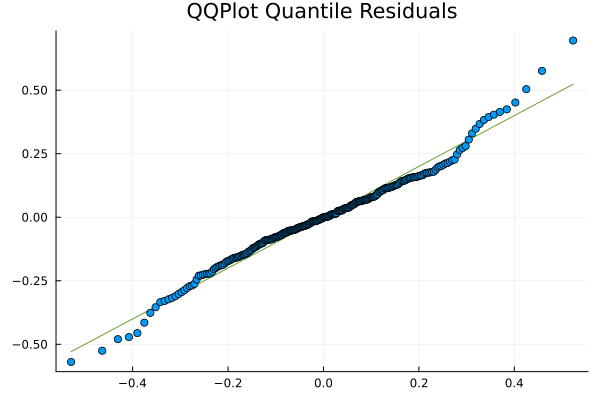

In [76]:
UnobservedComponentsGAS.plot_qqplot(fitted_model; type = "q")

## Hypothesis Tests

It is also commom practice to perform certain hypothesis tests in order to verify residuals normality, lack of autocorrelation and homocedasticity.

With that in mind, the package offers some built in functions:

 - *jarquebera(output; type)*: 
    - Jarque-Bera Test for normality

 - *ljungbox(output; type, squared, lags)*: 
    - Ljung-Box test for lack of autocorrelation

 - *test_H(output; type)*:
   -  H test for uncondicional heterocedasticity
 
 - *archtest(output; type, lags)*: 
    - ARCH test for condicional heterocedasticity

All functions have both the fitted model's output and the residuals' type as parameter. The *ljungboxtest()* also receives a boolean flag *squared* and an integer for the number of lags. The *archtest()* also receives the number of lags as integer.

Each function returns a dictionary with, at least, the test statistic and it's pvalue. Some functions have extra return values.

In [77]:
UnobservedComponentsGAS.jarquebera(fitted_model; type = "std")

Dict{String, Float64} with 4 entries:
  "stat"   => 50.1708
  "pvalue" => 1.27511e-11
  "kurt"   => 5.01301
  "skew"   => 0.225041

In [78]:
UnobservedComponentsGAS.ljungbox(fitted_model; type = "std", squared = false, lags = 13)

Dict{String, Float64} with 2 entries:
  "stat"   => 51.2796
  "pvalue" => 1.79559e-6

In [79]:
UnobservedComponentsGAS.ljungbox(fitted_model; type = "std", squared = true, lags = 13)

Dict{String, Float64} with 2 entries:
  "stat"   => 59.9951
  "pvalue" => 5.26399e-8

In [80]:
UnobservedComponentsGAS.Htest(fitted_model; type = "std")

Dict{String, Float64} with 2 entries:
  "stat"   => 0.958739
  "pvalue" => 0.838712

In [81]:
UnobservedComponentsGAS.archtest(fitted_model; type = "std", lags = 13)

Dict{String, Float64} with 2 entries:
  "stat"   => 44.804
  "pvalue" => 2.25626e-5

### All in one function

The package has a built-in function that returns the pvalues for all the impemented hypothesis tests:
 - *get_residuals_diagnosis_pvalues(output; lags, type"q")*

In [82]:
UnobservedComponentsGAS.get_residuals_diagnosis_pvalues(fitted_model; lags = 13, type = "std")

Dict{String, Float64} with 5 entries:
  "HVariance"       => 0.838712
  "LjungBoxSquared" => 5.26399e-8
  "JarqueBera"      => 1.27511e-11
  "ARCH"            => 2.25626e-5
  "LjungBox"        => 1.79559e-6